In [87]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [88]:
def show_tiff(tiff_path, cmap='terrain'):
    """Display a single TIFF in Jupyter"""
    with rasterio.open(tiff_path) as src:
        data = src.read(1).astype(float)
        if src.nodata is not None:
            data[data == src.nodata] = np.nan

        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap)
        plt.colorbar(label='Height (m)')
        plt.title(Path(tiff_path).stem)
        plt.axis('off')
        plt.show()

In [89]:
def inspect_tiff(tiff_path):
    """Comprehensive inspection of TIFF file contents"""

    print(f"🔍 INSPECTING: {Path(tiff_path).name}")
    print("="*60)

    with rasterio.open(tiff_path) as src:
        # Basic file info
        print(f"📋 BASIC INFO:")
        print(f"  Dimensions: {src.width} x {src.height}")
        print(f"  Bands: {src.count}")
        print(f"  Data types: {src.dtypes}")
        print(f"  CRS: {src.crs}")
        print(f"  Resolution: {src.res}")
        print(f"  Bounds: {src.bounds}")
        print(f"  NoData: {src.nodata}")

        # Metadata
        print(f"\n📝 METADATA:")
        if src.tags():
            for key, value in src.tags().items():
                print(f"  {key}: {value}")
        else:
            print("  No metadata found")

        # Band descriptions
        print(f"\n📊 BAND INFORMATION:")
        for i in range(1, src.count + 1):
            print(f"\n  BAND {i}:")

            # Band metadata
            band_tags = src.tags(i)
            if band_tags:
                for key, value in band_tags.items():
                    print(f"    {key}: {value}")

            # Read sample data
            data = src.read(i)

            # Handle nodata
            if src.nodata is not None:
                valid_data = data[data != src.nodata]
            else:
                valid_data = data.flatten()

            if len(valid_data) > 0:
                print(f"    Data type: {data.dtype}")
                print(f"    Valid pixels: {len(valid_data):,} / {data.size:,} ({len(valid_data)/data.size*100:.1f}%)")
                print(f"    Range: {valid_data.min():.3f} to {valid_data.max():.3f}")
                print(f"    Mean: {valid_data.mean():.3f}")
                print(f"    Std: {valid_data.std():.3f}")

                # Check for common LiDAR data patterns
                unique_vals = np.unique(valid_data)
                if len(unique_vals) < 20:
                    print(f"    Unique values: {unique_vals}")
                    print(f"    → Likely classification/categorical data")
                elif valid_data.max() < 100:
                    print(f"    → Possibly intensity, return info, or relative heights")
                elif 100 <= valid_data.max() < 5000:
                    print(f"    → Likely elevation data (meters)")
                else:
                    print(f"    → Possibly elevation in different units")
            else:
                print(f"    No valid data found")

        # Color interpretation (if available)
        print(f"\n🎨 COLOR INTERPRETATION:")
        for i in range(1, src.count + 1):
            color_interp = src.colorinterp[i-1]
            print(f"  Band {i}: {color_interp}")

        # Overviews
        print(f"\n🔍 OVERVIEWS:")
        for i in range(1, src.count + 1):
            overviews = src.overviews(i)
            if overviews:
                print(f"  Band {i}: {len(overviews)} overview levels")
            else:
                print(f"  Band {i}: No overviews")

In [90]:
# Simple DEM Comparison Analysis
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Additional analysis imports
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xarray as xr
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

TARGET_CRS = 'EPSG:32632'  # UTM 32N
resolution = 10  # meters
NODATA = -9999
saocom_files = list(DATA_DIR.glob("verona_v2*"))

In [91]:
"""Load SAOCOM point data"""
# Try different separators

df = pd.read_csv(saocom_files[0], sep=',')
# Standardize column names
cols = df.columns.str.upper().str.strip()
mapping = {'LAT': 'lat', 'LON': 'lon', 'HEIGHT': 'height', 'COHER': 'coherence'}

for old, new in mapping.items():
    if old in cols:
        df = df.rename(columns={old: new})

# Clean data
for col in ['lat', 'lon', 'height', 'coherence']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['lat', 'lon', 'height'])
df = df[df['coherence'] >= 0.3]  # Filter by coherence

# Convert to GeoDataFrame and reproject
geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
gdf = gdf.to_crs(TARGET_CRS)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

In [92]:
"""
Convert SAOCOM CSV point data to a raster in EPSG:32632 using interpolation.

This script reads a SAOCOM CSV file, filters points based on coherence, reprojects
them to UTM zone 32N, interpolates the height data onto a grid, and saves the
result as a GeoTIFF. It also generates and saves a plot visualizing the results.

Dependencies:
- numpy
- pandas
- geopandas
- shapely
- rasterio
- scipy
- matplotlib
- pathlib

You may need to install these libraries first using pip:
pip install numpy pandas geopandas rasterio scipy matplotlib
"""
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pathlib import Path

def read_saocom_csv(csv_path, coherence_threshold=0.3):
    """
    Read SAOCOM CSV data and apply coherence filtering.

    Parameters:
    -----------
    csv_path : str or Path
        Path to SAOCOM CSV file
    coherence_threshold : float
        Minimum coherence value to keep points

    Returns:
    --------
    geopandas.GeoDataFrame
        Projected point data in EPSG:32632
    """
    # Try to read CSV - handle different separators and formats
    with open(csv_path, 'r') as f:
        first_line = f.readline()

    columns = ['ID', 'SVET', 'LVET', 'LAT', 'LON', 'HEIGHT',
              'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']
    df = pd.read_csv(csv_path, sep=',', names=columns, skiprows=1)
    # Standardize column names (handle variations)
    column_mapping = {
        'LAT': 'LAT', 'LATITUDE': 'LAT', 'lat': 'LAT',
        'LON': 'LON', 'LONGITUDE': 'LON', 'lon': 'LON', 'LONG': 'LON',
        'HEIGHT': 'HEIGHT', 'ELEVATION': 'HEIGHT', 'ELEV': 'HEIGHT',
        'COHER': 'COHER', 'COHERENCE': 'COHER', 'COH': 'COHER'
    }

    # Clean column names and apply mapping
    df.columns = [col.strip().upper() for col in df.columns]
    df = df.rename(columns=column_mapping)

    # Convert to numeric
    for col in ['LAT', 'LON', 'HEIGHT', 'COHER']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove invalid points
    df = df.dropna(subset=['LAT', 'LON', 'HEIGHT'])
    df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

    # Apply coherence filter if available
    if 'COHER' in df.columns:
        df = df[df['COHER'] >= coherence_threshold]

    # Create GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df['LON'], df['LAT'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

    # Reproject to UTM 32N
    gdf_utm = gdf.to_crs('EPSG:32632')

    # Add UTM coordinates as columns
    gdf_utm['X'] = gdf_utm.geometry.x
    gdf_utm['Y'] = gdf_utm.geometry.y

    return gdf_utm

def points_to_raster(gdf, resolution=10, method='linear'):
    """
    Convert point data to a raster using interpolation.

    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        Point data with X, Y, HEIGHT columns
    resolution : float
        Pixel size in meters
    method : str
        Interpolation method ('linear', 'nearest', 'cubic')

    Returns:
    --------
    tuple
        (raster_array, transform, bounds)
    """
    # Get bounds from the GeoDataFrame
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds

    # Create grid using np.arange
    x = np.arange(xmin, xmax + resolution, resolution)
    y = np.arange(ymax, ymin - resolution, -resolution)
    grid_x, grid_y = np.meshgrid(x, y)

    # Extract point coordinates and values
    points = np.column_stack((gdf['X'].values, gdf['Y'].values))
    values = gdf['HEIGHT'].values

    # Interpolate
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    grid_values = griddata(points, values, grid_points, method=method, fill_value=np.nan)
    raster_array = grid_values.reshape(grid_x.shape)

    # Create transform
    transform = from_bounds(xmin, ymin, xmax, ymax, len(x), len(y))
    return raster_array, transform, (xmin, ymin, xmax, ymax)


def save_raster(array, transform, output_path, crs='EPSG:32632', nodata=-9999):
    """
    Save raster array to GeoTIFF.

    Parameters:
    -----------
    array : numpy.ndarray
        Raster data
    transform : rasterio.transform.Affine
        Geotransform
    output_path : str or Path
        Output file path
    crs : str
        Coordinate reference system
    nodata : float
        NoData value
    """
    # Replace NaN with nodata value
    array_out = array.copy()
    array_out[np.isnan(array_out)] = nodata

    # Write to file
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=array.shape[0],
        width=array.shape[1],
        count=1,
        dtype=array.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
        compress='lzw'
    ) as dst:
        dst.write(array_out, 1)


def main():
    """
    Main conversion workflow
    """
    # Configuration
    config = {
        'input_csv': 'data/verona_v2.csv',  # <--- CHANGE THIS TO YOUR CSV FILE PATH
        'output_dir': Path('results/saocom_raster'),
        'resolution': 10,  # meters
        'coherence_threshold': 0.3,
        'interpolation_method': 'cubic',  # 'linear', 'nearest', or 'cubic'
    }

    # Create output directory
    config['output_dir'].mkdir(parents=True, exist_ok=True)

    # Step 1: Read and project CSV data
    gdf = read_saocom_csv(
        config['input_csv'],
        coherence_threshold=config['coherence_threshold']
    )

    # Save projected points for reference
    points_output = config['output_dir'] / "saocom_points_utm32n.gpkg"
    gdf.to_file(points_output, driver="GPKG")

    # Step 2: Convert to raster
    raster_array, transform, bounds = points_to_raster(
        gdf,
        resolution=config['resolution'],
        method=config['interpolation_method']
    )

    # Step 3: Save raster
    raster_output = config['output_dir'] / f"saocom_dem_utm32n_{config['resolution']}m.tif"
    save_raster(raster_array, transform, raster_output)

    # Step 4: Create visualization

# This block executes the main function when the cell is run
main()


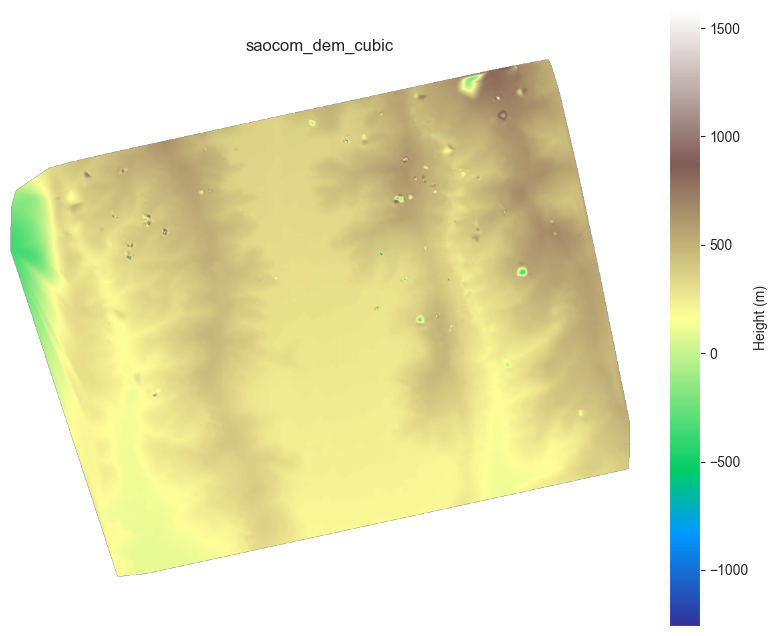

In [93]:
"""Convert points to regular grid"""
method = 'cubic'
# Define grid bounds
bounds = gdf.total_bounds
xmin, ymin, xmax, ymax = bounds

# Create grid
x = np.arange(xmin, xmax + resolution, resolution)
y = np.arange(ymax, ymin - resolution, -resolution)  # Flip Y direction
grid_x, grid_y = np.meshgrid(x, y)

# Interpolate
points_xy = np.column_stack([gdf['x'], gdf['y']])
values = gdf['height'].values
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

grid_values = griddata(points_xy, values, grid_points, method=method, fill_value=NODATA)
saocom_grid = grid_values.reshape(grid_x.shape)

# Save as GeoTIFF
transform = from_bounds(xmin, ymin, xmax, ymax, len(x), len(y))

saocom_raster_path = RESULTS_DIR / f"saocom_dem_{method}.tif"
with rasterio.open(saocom_raster_path, 'w', driver='GTiff', height=saocom_grid.shape[0],
                   width=saocom_grid.shape[1], count=1, dtype='float32',
                   crs=TARGET_CRS, transform=transform, nodata=NODATA) as dst:
    dst.write(saocom_grid.astype('float32'), 1)
show_tiff(saocom_raster_path)



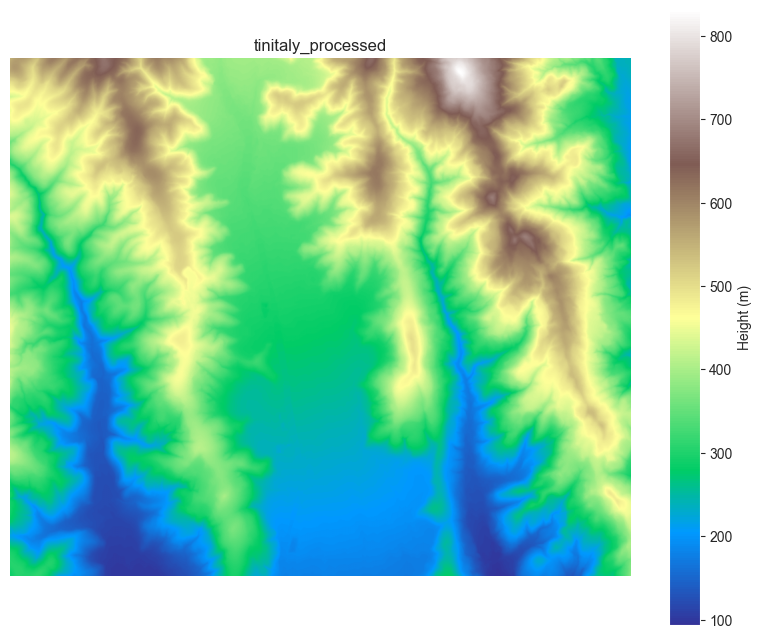

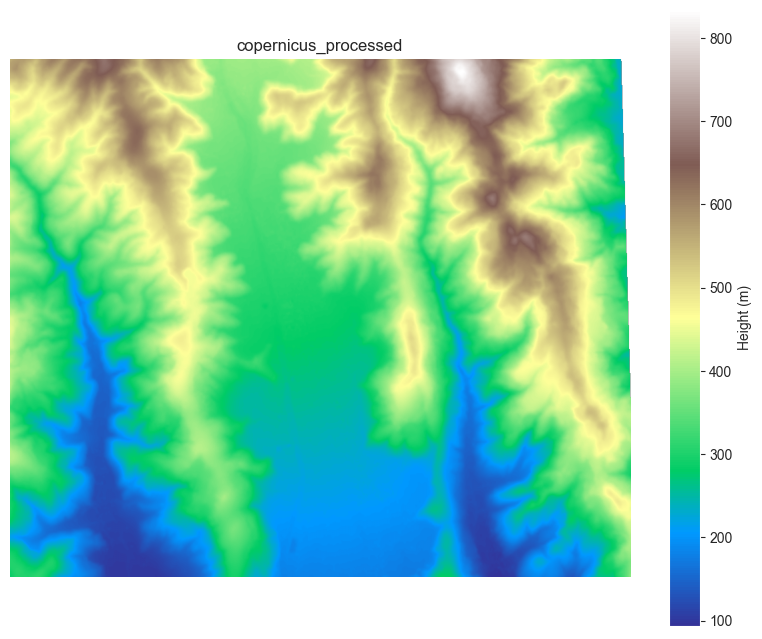

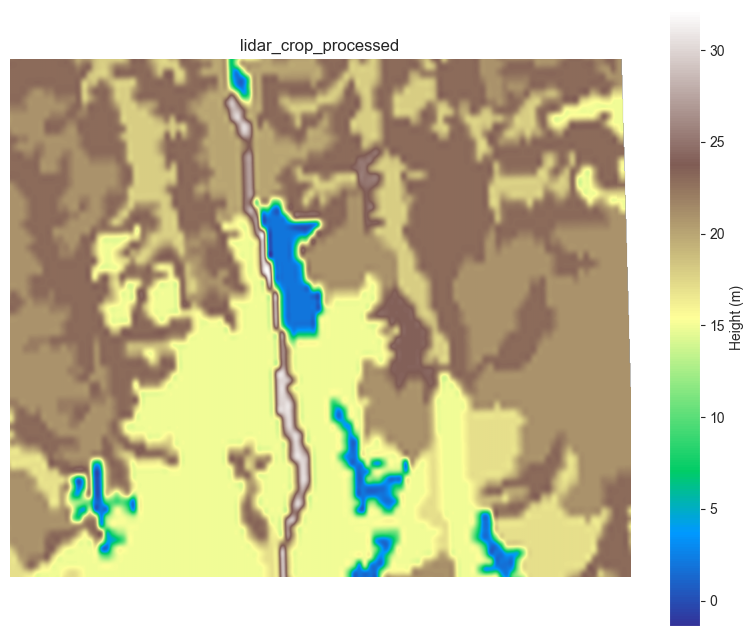

In [94]:
def process_reference_dem(dem_path, target_bounds, target_transform, target_width, target_height):
    """Reproject and resample DEM to target grid"""
    output_path = RESULTS_DIR / f"{dem_path.stem}_processed.tif"

    with rasterio.open(dem_path) as src:
        # Setup output profile
        profile = {
            'driver': 'GTiff',
            'dtype': 'float32',
            'width': target_width,
            'height': target_height,
            'count': 1,
            'crs': TARGET_CRS,
            'transform': target_transform,
            'nodata': NODATA
        }

        # Create output array
        output_array = np.full((target_height, target_width), NODATA, dtype=np.float32)

        # Reproject
        reproject(
            source=rasterio.band(src, 1),
            destination=output_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.cubic,
            src_nodata=src.nodata,
            dst_nodata=NODATA
        )
        # Check result
        valid_pixels = np.sum(output_array != NODATA)
        if valid_pixels > 0:
            valid_data = output_array[output_array != NODATA]

        # Save
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(output_array, 1)
        show_tiff(output_path)
    return output_path

reference_dems = {}
if 'saocom_grid' in locals():
    # Get target grid from SAOCOM
    bounds = [grid_x.min(), grid_y.min(), grid_x.max(), grid_y.max()]
    transform = from_bounds(*bounds, grid_x.shape[1], grid_x.shape[0])

    # Find and process reference DEMs
    dem_patterns = {
        'tinitaly': '*tinitaly*',
        'copernicus': '*GLO30*',
        'lidar_crop': '*lidar*'
    }

    for name, pattern in dem_patterns.items():
        dem_files = list(DATA_DIR.glob(f"{name}.tif")) + list(DATA_DIR.glob(f"{name}.TIF"))
        if dem_files:
            processed_path = process_reference_dem(
                dem_files[0], bounds, transform, grid_x.shape[1], grid_x.shape[0]
            )
            reference_dems[name] = processed_path


In [95]:
from shapely.geometry import box
def calibrate_saocom(saocom_path, tinitaly_path):
    """Calibrate SAOCOM heights using TINITALY reference"""

    # Get SAOCOM bounds
    with rasterio.open(saocom_path) as src:
        saocom_bounds = src.bounds
        clip_geom = box(*saocom_bounds)

    # Clip TINITALY to SAOCOM extent
    with rasterio.open(tinitaly_path) as src:
        clipped_data, _ = rasterio.mask.mask(src, [clip_geom], crop=True)
        tinitaly_data = clipped_data[0]
        tinitaly_valid = tinitaly_data[(tinitaly_data != src.nodata) & (~np.isnan(tinitaly_data))]

    # Get SAOCOM average
    with rasterio.open(saocom_path) as src:
        saocom_data = src.read(1).astype(float)
        saocom_valid = saocom_data[(saocom_data != src.nodata) & (~np.isnan(saocom_data))]

    # Calculate bias and adjustment
    tinitaly_avg = np.mean(tinitaly_valid)
    saocom_avg = np.mean(saocom_valid)
    adjustment = tinitaly_avg - saocom_avg

    print(f"TINITALY avg: {tinitaly_avg:.1f}m, SAOCOM avg: {saocom_avg:.1f}m")
    print(f"Applying adjustment: {adjustment:+.1f}m")

    # Apply adjustment to SAOCOM
    with rasterio.open(saocom_path) as src:
        data = src.read(1).astype(np.float32)
        valid_mask = (data != src.nodata) & (~np.isnan(data))
        data[valid_mask] += adjustment

        # Save adjusted version
        output_path = Path(saocom_path).parent / f"{Path(saocom_path).stem}_calibrated.tif"
        profile = src.profile.copy()

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data, 1)

    print(f"Saved calibrated SAOCOM: {output_path.name}")
    return output_path

calibrated_saocom = calibrate_saocom(saocom_raster_path, reference_dems['tinitaly'])

TINITALY avg: 355.8m, SAOCOM avg: 335.1m
Applying adjustment: +20.7m
Saved calibrated SAOCOM: saocom_dem_cubic_calibrated.tif


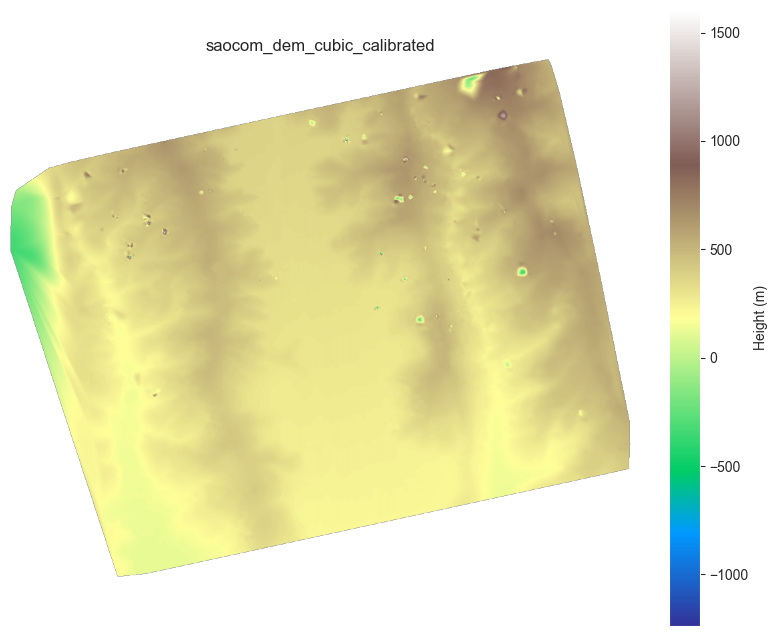

In [96]:
show_tiff(calibrated_saocom)

Week 3 - QA/QC


In [97]:
# SAOCOM QA/QC Analysis - Week 2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
from scipy import stats
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# File paths - update these
SAOCOM_PATH = "path/to/saocom_data.tif"
COHERENCE_PATH = "path/to/coherence.tif"
CORINE_PATH = "path/to/corine_land_cover.shp"
REFERENCE_PATHS = {
    'DEM1': "path/to/reference1.tif",
    'DEM2': "path/to/reference2.tif",
    'DEM3': "path/to/reference3.tif"
}

# Parameters
COHERENCE_THRESHOLD = 0.3

with rasterio.open(COHERENCE_PATH) as src:
    coherence = src.read(1)
    coherence_profile = src.profile

# Coherence statistics
valid_coh = coherence[coherence > 0]
print(f"Coherence Stats:")
print(f"Mean: {np.mean(valid_coh):.3f}")
print(f"Std: {np.std(valid_coh):.3f}")
print(f"Min: {np.min(valid_coh):.3f}")
print(f"Max: {np.max(valid_coh):.3f}")
print(
    f"Pixels < {COHERENCE_THRESHOLD}: {np.sum(coherence < COHERENCE_THRESHOLD)} ({100 * np.sum(coherence < COHERENCE_THRESHOLD) / coherence.size:.1f}%)")

# Plot distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(valid_coh, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(COHERENCE_THRESHOLD, color='red', linestyle='--', label=f'Threshold = {COHERENCE_THRESHOLD}')
ax1.set_xlabel('Coherence')
ax1.set_ylabel('Frequency')
ax1.set_title('Coherence Distribution')
ax1.legend()

show(coherence, ax=ax2, title='Coherence Map', cmap='viridis')
plt.tight_layout()
plt.show()

mask_nodata = coherence < COHERENCE_THRESHOLD
print(f"No-data mask created: {np.sum(mask_nodata)} pixels masked")

# Visualize mask
plt.figure(figsize=(10, 6))
plt.imshow(mask_nodata, cmap='RdYlBu_r')
plt.colorbar(label='Masked (1) / Valid (0)')
plt.title('No-Data Mask (γ < 0.3)')
plt.show()

try:
    corine = gpd.read_file(CORINE_PATH)

    # Convert mask to raster for zonal stats
    from rasterstats import zonal_stats

    # Calculate stats for each land cover class
    stats_list = zonal_stats(corine, mask_nodata.astype(np.uint8),
                             affine=coherence_profile['transform'],
                             stats=['mean', 'count'])

    corine['masked_pct'] = [s['mean'] * 100 if s['mean'] is not None else 0 for s in stats_list]
    corine['pixel_count'] = [s['count'] if s['count'] is not None else 0 for s in stats_list]

    # Summary by land cover class
    lc_summary = corine.groupby('CODE_18').agg({
        'masked_pct': 'mean',
        'pixel_count': 'sum'
    }).round(2)

    print("Masked percentage by CORINE land cover class:")
    print(lc_summary.head(10))

except Exception as e:
    print(f"CORINE analysis failed: {e}")
    print("Continuing with raster-only analysis...")


def identify_gaps(mask, title="Gaps Analysis"):
    """Identify clusters of no-data pixels"""
    from scipy import ndimage

    # Label connected components
    labeled, num_features = ndimage.label(mask)

    # Calculate size of each gap
    gap_sizes = []
    for i in range(1, num_features + 1):
        gap_size = np.sum(labeled == i)
        gap_sizes.append(gap_size)

    gap_sizes = np.array(gap_sizes)
    large_gaps = gap_sizes[gap_sizes > 1000]  # Gaps > 1000 pixels

    print(f"\n{title}:")
    print(f"Total gaps: {num_features}")
    print(f"Large gaps (>1000 px): {len(large_gaps)}")
    print(f"Largest gap size: {np.max(gap_sizes) if len(gap_sizes) > 0 else 0} pixels")

    return labeled, gap_sizes


labeled_gaps, gap_sizes = identify_gaps(mask_nodata, "Systematic Gaps")

# Plot gap distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(gap_sizes, bins=50, alpha=0.7)
plt.xlabel('Gap Size (pixels)')
plt.ylabel('Frequency')
plt.title('Gap Size Distribution')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.imshow(labeled_gaps, cmap='tab20')
plt.title('Identified Gap Clusters')
plt.colorbar()
plt.tight_layout()
plt.show()

with rasterio.open(SAOCOM_PATH) as src:
    saocom = src.read(1)
    saocom_profile = src.profile

# Apply mask to SAOCOM
saocom_masked = np.where(mask_nodata, np.nan, saocom)

# Load reference datasets
reference_data = {}
for name, path in REFERENCE_PATHS.items():
    try:
        with rasterio.open(path) as src:
            ref_data = src.read(1)
            reference_data[name] = ref_data
        print(f"Loaded {name}: {ref_data.shape}")
    except Exception as e:
        print(f"Failed to load {name}: {e}")

n_refs = len(reference_data)
fig, axes = plt.subplots(2, n_refs, figsize=(5 * n_refs, 8))
if n_refs == 1:
    axes = axes.reshape(-1, 1)

for i, (name, ref_data) in enumerate(reference_data.items()):
    # Calculate difference
    diff = saocom_masked - ref_data

    # Statistics
    valid_diff = diff[~np.isnan(diff)]
    mean_diff = np.mean(valid_diff)
    std_diff = np.std(valid_diff)

    print(f"\n{name} vs SAOCOM:")
    print(f"  Mean difference: {mean_diff:.3f} m")
    print(f"  Std difference: {std_diff:.3f} m")
    print(f"  Range: {np.min(valid_diff):.3f} to {np.max(valid_diff):.3f} m")

    # Plot difference map
    im1 = axes[0, i].imshow(diff, cmap='RdBu_r', vmin=-10, vmax=10)
    axes[0, i].set_title(f'SAOCOM - {name}\nMean: {mean_diff:.2f}±{std_diff:.2f}m')
    plt.colorbar(im1, ax=axes[0, i])

    # Histogram
    axes[1, i].hist(valid_diff, bins=50, alpha=0.7, edgecolor='black')
    axes[1, i].axvline(0, color='red', linestyle='--')
    axes[1, i].axvline(mean_diff, color='green', linestyle='-', label=f'Mean: {mean_diff:.2f}')
    axes[1, i].set_xlabel('Elevation Difference (m)')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].legend()

plt.tight_layout()
plt.show()


def check_systematic_errors(diff_data, name):
    """Check for ramps, offsets, and striping patterns"""
    valid_data = diff_data[~np.isnan(diff_data)]

    print(f"\n=== Systematic Error Check: {name} ===")

    # 1. Constant offset check
    median_offset = np.median(valid_data)
    print(f"Median offset: {median_offset:.3f} m")

    # 2. Linear ramp detection (simplified)
    rows, cols = np.where(~np.isnan(diff_data))
    if len(rows) > 100:
        # Fit plane: z = ax + by + c
        A = np.column_stack([cols, rows, np.ones(len(rows))])
        coeffs, residuals, rank, s = np.linalg.lstsq(A, diff_data[rows, cols], rcond=None)
        x_slope, y_slope, offset = coeffs

        print(f"Linear trends - X: {x_slope:.6f} m/pixel, Y: {y_slope:.6f} m/pixel")

        # 3. Striping detection (variance along rows/cols)
        row_var = np.nanvar(diff_data, axis=1)
        col_var = np.nanvar(diff_data, axis=0)

        print(f"Row variance range: {np.nanmin(row_var):.3f} - {np.nanmax(row_var):.3f}")
        print(f"Col variance range: {np.nanmin(col_var):.3f} - {np.nanmax(col_var):.3f}")

        # Flag potential striping
        row_var_ratio = np.nanmax(row_var) / np.nanmean(row_var) if np.nanmean(row_var) > 0 else 0
        col_var_ratio = np.nanmax(col_var) / np.nanmean(col_var) if np.nanmean(col_var) > 0 else 0

        if row_var_ratio > 5:
            print("WARNING: Potential horizontal striping detected!")
        if col_var_ratio > 5:
            print("WARNING: Potential vertical striping detected!")


# Check each difference map
for name, ref_data in reference_data.items():
    diff = saocom_masked - ref_data
    check_systematic_errors(diff, name)


def extract_profile(data, start_row, start_col, end_row, end_col):
    """Extract elevation profile along a line"""
    from skimage.draw import line

    rr, cc = line(start_row, start_col, end_row, end_col)
    # Keep within bounds
    valid_idx = (rr >= 0) & (rr < data.shape[0]) & (cc >= 0) & (cc < data.shape[1])
    rr, cc = rr[valid_idx], cc[valid_idx]

    profile = data[rr, cc]
    distances = np.sqrt((rr - start_row) ** 2 + (cc - start_col) ** 2)

    return distances, profile


# Define representative transects (update coordinates for your area)
transects = [
    {"name": "North-South", "coords": (50, 100, 400, 100)},
    {"name": "East-West", "coords": (200, 50, 200, 350)},
    {"name": "Diagonal", "coords": (50, 50, 400, 350)}
]

fig, axes = plt.subplots(len(transects), 1, figsize=(12, 4 * len(transects)))
if len(transects) == 1:
    axes = [axes]

for i, transect in enumerate(transects):
    r1, c1, r2, c2 = transect["coords"]

    # Extract SAOCOM profile
    dist, saocom_prof = extract_profile(saocom_masked, r1, c1, r2, c2)
    axes[i].plot(dist, saocom_prof, 'b-', linewidth=2, label='SAOCOM', alpha=0.8)

    # Extract reference profiles
    colors = ['red', 'green', 'orange', 'purple']
    for j, (name, ref_data) in enumerate(reference_data.items()):
        _, ref_prof = extract_profile(ref_data, r1, c1, r2, c2)
        axes[i].plot(dist, ref_prof, color=colors[j % len(colors)],
                     linestyle='--', label=name, alpha=0.7)

    axes[i].set_xlabel('Distance (pixels)')
    axes[i].set_ylabel('Elevation (m)')
    axes[i].set_title(f'Elevation Profile: {transect["name"]}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("SAOCOM QA/QC SUMMARY REPORT")
print("=" * 50)

print(f"\n1. COHERENCE ANALYSIS:")
print(f"   - Mean coherence: {np.mean(valid_coh):.3f}")
print(f"   - Pixels below threshold: {100 * np.sum(coherence < COHERENCE_THRESHOLD) / coherence.size:.1f}%")

print(f"\n2. SPATIAL COVERAGE:")
print(f"   - Total gaps identified: {len(gap_sizes)}")
print(f"   - Large gaps (>1000px): {len([g for g in gap_sizes if g > 1000])}")

print(f"\n3. ELEVATION DIFFERENCES:")
for name, ref_data in reference_data.items():
    diff = saocom_masked - ref_data
    valid_diff = diff[~np.isnan(diff)]
    print(f"   - {name}: {np.mean(valid_diff):.2f} ± {np.std(valid_diff):.2f} m")

print(f"\n4. SYSTEMATIC ERRORS:")
print("   - See detailed analysis above for ramps, offsets, and striping")

print(f"\n5. RECOMMENDATIONS:")
if np.sum(coherence < COHERENCE_THRESHOLD) / coherence.size > 0.3:
    print("   - High percentage of low-coherence pixels - check processing parameters")
if any([len([g for g in gap_sizes if g > 10000]) > 0]):
    print("   - Very large gaps present - investigate data acquisition issues")

print("\nQA/QC analysis complete.")

RasterioIOError: path/to/coherence.tif: No such file or directory